In [1]:
import numpy as np
import pandas as pd

import torch

from matplotlib import pyplot as plt

from collections import deque

from pid import PIDModel
from agent import Agent, Actor, Critic

%matplotlib inline

## Loading up Actor and Critic models

In [2]:
args = {
    "NUM_EPISODES": 10,
    "LEARNING_RATE": 0.01,
    "DEVICE": "cpu",
    "exploration_stddev": 0.2,
    "LOAD_PREVIOUS": False,
    "PRINT_EVERY": 50
}

In [21]:
T_SIZE = 500
SET_POINT = 50

t = np.linspace(0, 100, num=T_SIZE)
SP = np.ones(T_SIZE)*SET_POINT

env = PIDModel(ku=1.396, tu=3.28, t=t, SP=SP)

actor = Actor()
critic = Critic()
agent = Agent(env, lr=args["LEARNING_RATE"], actor_model=actor, critic_model=critic,
              device=args["DEVICE"])

print(agent.get_action(torch.Tensor([0.5, 0.5, 3, 10, 10])))
agent.load()
print(agent.get_action(torch.Tensor([0.5, 0.5, 3, 10, 10])))

tensor([0.5486, 0.5486, 3.6458], grad_fn=<AddBackward0>)
tensor([0.5467, 0.5511, 3.6603], grad_fn=<AddBackward0>)


Emulating some episodes
---

In [22]:
state = env.reset()
done = False
total = 0

agent.start_episode()
state, init_reward, __ = env.step((0.5, 0.5, 3.5))  # Initial random state
num_step = 0
rewards = [init_reward]
states = [state]
while not done:
    action = agent.get_action(state)

    new_state, reward, done = env.step(action)
    agent.step(state, action, action, reward)

    total += reward
    state = new_state
    num_step += 1
    rewards.append(reward)
    states.append(state)

y_caps = np.array(env.output())

/usr/lib64/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [23]:
states

[(0.5, 0.5, 3.5, 50.0, 249.5),
 (tensor(0.8164, grad_fn=<SelectBackward>),
  tensor(0.8323, grad_fn=<SelectBackward>),
  tensor(4.5163, grad_fn=<SelectBackward>),
  49.16812920332888,
  -4.151035275388883),
 (tensor(0.5798, grad_fn=<SelectBackward>),
  tensor(0.5864, grad_fn=<SelectBackward>),
  tensor(3.7690, grad_fn=<SelectBackward>),
  44.909440577510566,
  -21.250856242833393),
 (tensor(0.5538, grad_fn=<SelectBackward>),
  tensor(0.5586, grad_fn=<SelectBackward>),
  tensor(3.6837, grad_fn=<SelectBackward>),
  38.255104987412764,
  -33.20513459458803),
 (tensor(0.5319, grad_fn=<SelectBackward>),
  tensor(0.5352, grad_fn=<SelectBackward>),
  tensor(3.6117, grad_fn=<SelectBackward>),
  31.546227597846556,
  -33.477298173935374),
 (tensor(0.5234, grad_fn=<SelectBackward>),
  tensor(0.5261, grad_fn=<SelectBackward>),
  tensor(3.5835, grad_fn=<SelectBackward>),
  26.746727944356838,
  -23.949503270913695),
 (tensor(0.5285, grad_fn=<SelectBackward>),
  tensor(0.5316, grad_fn=<SelectBackwa

In [24]:
y_caps

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 8.31870797e-01,  1.18857135e+01,  1.07088880e+02],
       ...,
       [ 5.00000004e+01, -1.81735175e-06,  7.39983762e-07],
       [ 5.00000000e+01, -1.66474737e-06,  7.67590704e-07],
       [ 4.99999997e+01, -1.51092158e-06,  7.67590704e-07]])

Text(0, 0.5, 'Response')

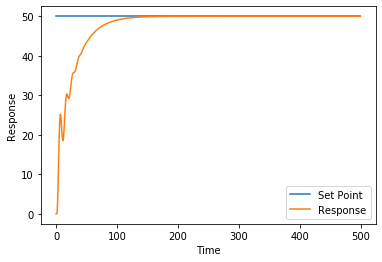

In [25]:
response = y_caps[:, 0]

plt.plot(SP, label="Set Point")
plt.plot(response, label="Response")

plt.legend()
plt.xlabel("Time")
plt.ylabel("Response")

Text(0.5, 0, 'Time')

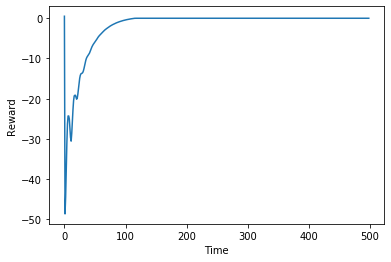

In [26]:
plt.plot(rewards)
plt.ylabel("Reward")
plt.xlabel("Time")

Text(0, 0.5, 'Error')

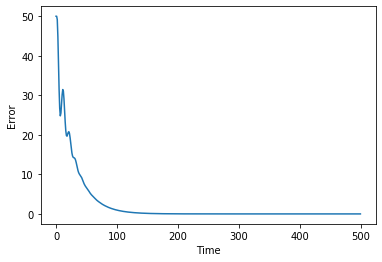

In [27]:
error = SP-response
plt.plot(error)
plt.xlabel("Time")
plt.ylabel("Error")

Text(0, 0.5, 'Derivative of error')

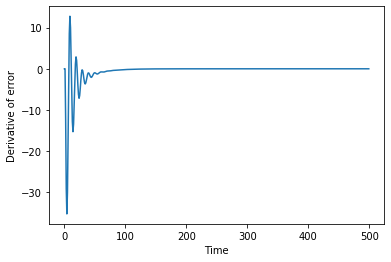

In [28]:
d_error = -y_caps[:, 1]
plt.plot(d_error)
plt.xlabel("Time")
plt.ylabel("Derivative of error")

In [29]:
# Max overshoot
error_pd = -pd.Series(error)

# Max overshoot is when |error| is maximum after touching the set point first, i.e after first crossing zero
first_cross = error_pd[((error_pd.shift() <= 0) & (error_pd >= 0))].index[0]

print("Max overshoot: ", error_pd[first_cross: ].abs().max())

Max overshoot:  2.1967661325561494e-06


In [31]:
# Settling time: first occurence of when tolerance band is reached
# tolerance band is +-TOLERANCE_BAND percent of the target set point

TOLERANCE_BAND = 5/100 # Within 0.5% of the target is tolerable
abs_tolerance = TOLERANCE_BAND*SP[0]

settling_time = t[error_pd[(error_pd.abs() < abs_tolerance)].index[0]]
print("Settling time: ", settling_time)

Settling time:  15.230460921843688
